# Markov Chain Monte Carlo (MCMC)

In [14]:
library(coda)
library(rjags)
library(rstan)
library(microbenchmark)
library(coda)

source("utils.R")
source("MH.R")
source("MH_customized.R")
source("rejection_sampler.R")
source("Gibbs.R")

## 4. Metropolis-Hastings

**Metropolis-Hastings** is an algorithm that allows us to sample from a **generic probability distribution** in ignorance of the normalizing constant.

The critical thing is not that we have $i.i.d.$ samples from $p(\theta \mid \mathbf{y})$ but rather that **we are able to construct a large collection of $\theta$ values**.

The algorithm uses a **Markov process** which asymptotically reaches a **unique stationary distribution** **$\pi(x)$** such that **$\pi(x)=P(x)$**

### Algorithm

1. Select an initial value $\theta_0$

2. For $(i = 1, \ldots, m)$, repeat the following steps:

    a. Draw a candidate sample $\theta^{*}$ from a proposal distribution $q(\theta^{x} \mid \theta_{i-1})$ 
    
    b. Compute the ratio
    
$$
\begin{aligned}
&\alpha = \frac{g(\theta^*) / q(\theta^* \mid \theta_{i-1}) }{g(\theta_{i-1}) / q(\theta_{i-1} \mid \theta^*)} = \frac{g(\theta^*)q(\theta_{i-1} \mid \theta^*)}{g(\theta_{i-1})q(\theta^* \mid \theta_{i-1})} \\
\end{aligned}
$$

   
   
$\ \ \ \ \ $ c. Proceed from $\theta_{i-1}$ to $\theta^{*}$ with the probability $A = min(1, \alpha)$.

### Proof

Let us define the following.

+ **proposal distribution** $\ \ g(x' \mid x)$ : conditional probability of proposing a state $x'$ given $x$.

+ **acceptance distribution** $\ \ A(x' \mid x)$ : conditional probability to accept the proposed state $x'$

The proof stands on the following **two assumptions**.

+ **existence of** $\pi(x)$. Let us assume here the Markov chain is **reversible**. i.e., it satisfies **detailed balance**. Thus,

$$
\pi(x) P(x' \mid x) = \pi(x') P(x \mid x')
$$

  
+ **uniqueness of ** $\pi(x)$. Let us assume here the every state in the Markov chain is **aperiodic** and **positive recurrent**. i.e. **ergodicity**

The **transition probability** can be written as follows.

$$
\begin{aligned}
P(x' \mid x) &= g(x' \mid x) A(x' \mid x) \\[10pt]
\frac {A(x' \mid x)} {A(x \mid x')} &= \frac {P(x')} {P(x)} \frac{g (x \mid x') } {g (x' \mid x) } \ \ \ \ \ \ \ \ \cdots (1)\\
\end{aligned}
$$

If we just set **A as follows**,

$$
A(x' \mid x) = min(1, \frac {P(x')}{P(x)}  \frac{g(x \mid x')} {g(x' \mid x)} )
$$

then **A satisfies (1)**, as shown below.

$$
\begin{aligned}
\frac {A(x' \mid x)} {A(x \mid x')} &= \frac { min(1, \frac {P(x')}{P(x)}  \frac{g(x \mid x')} {g(x' \mid x)} ) } 
                                             { min(1, \frac {P(x)}{P(x')}  \frac{g(x' \mid x)} {g(x \mid x')} ) }\\[15pt]
                                    &= \frac {P(x')} {P(x)} \frac{g (x \mid x') } {g (x' \mid x) } \\
\end{aligned}
$$

### Example1 : Discrete Case

**Prior** $P(\theta = \text{loaded}) = 0.6$  ($\theta = \{ \text{fair, loaded} \}$)

**Likelihood** $f(x \mid \theta) = \dbinom{5}{x}(\frac{1}{2})^5 I_{\{\theta=\text{fair}\}} + \dbinom{5}{x}(0.7)^x (0.3)^{5-x}I_{\{\theta=\text{loaded}\}} $

**Posterior** 

$$
\begin{aligned}
f(\theta \mid X=2) &= \frac{ f(x=2 \mid \theta) f(\theta) }  {f(x)} \\[10pt]
&\propto (1/2)^5 (0.4) I_{\{\theta=\text{fair}\}} + (0.7)^2 (0.3)^3 (6) I_{\{\theta=\text{loaded}\}} \\[10pt]
&= g(x) \\
\end{aligned}
$$

**Algorithm**

$$
\begin{aligned}
\alpha &= \frac{g(\theta^{*}) / q(\theta^{*} \mid \theta_{i-1})}  {g(\theta_{i-1}) / q(\theta_{i-1} \mid \theta^{*})} \\[10pt]
&= \frac {f(x=2 \mid \theta^{*}) f(\theta^{*}) / 1}    {f(x=2 \mid \theta_{i-1}) f(\theta_{i-1}) / 1}
\end{aligned}
$$

If $\theta^{*}=\text{fair}$, $\alpha = 1.574 > 1$ accept $\theta^{*}$, set $\theta_i = \text{fair}$.

If $\theta^{*}=\text{loaded}$, $\alpha = 0.635 > 1$ accept $\theta^{*}$ with probability $0.635$, set $\theta_i = \text{fair}$.

**Transition Matrix & Stationary Distribution**

$$
\begin{aligned}
\pi P &= \pi \\[10pt]
P &= \begin{bmatrix}
0.365 & 0.635 \\
1 & 0 \\
\end{bmatrix}\\[10pt]
\pi &= [0.612, \ \ 0.388] \\
\end{aligned}
$$

### Example2 : Continuous Case

**Percent change in total personnel** of $n=10$ companies for 1 year.

+ **Prior** $\mu \sim t(0, 1, 1)$

+ **Likelihood** $\mathbf{y} \mid \mu \sim N(\mu, 1)$

+ **Goal** $\mu \mid \mathbf{y} \sim ?$

$$
\begin{aligned}
p(\mu \mid y_1, \ldots, y_n) &\propto \frac { exp(n (\bar{y} \mu - \mu^2/2)  }  {1 + \mu^2} \\[15pt]
\text{We have, } \mathbf{y} &= (1.2,1.4,−0.5,0.3,0.9,2.3,1.0,0.1,1.3,1.9)
\end{aligned}
$$

In [2]:
y = c(1.2, 1.4, -0.5, 0.3, 0.9, 2.3, 1.0, 0.1, 1.3, 1.9)
n = length(y)
ybar = mean(y)

### Demonstration

#### 1. MCMC with Dependent Symmetric Proposal

**Proposal Distribution**

+ $\theta^{*} \sim N(\theta_{i-1}, 1)$

+ $\theta_0 = 2$

In [3]:
X = MH(g, 1000, method = "dep.sym", theta_init=2, sd_proposal=1)
X_mcmc = as.mcmc(X$theta)

#### 2. MCMC with Dependent Asymmetric Proposal

**Proposal Distribution**

+ $\theta^{*} \sim IG(\theta_{i-1}, 1)$

+ $\theta_0 = 2$

In [4]:
X_asym = MH(g, 1000, method = "dep.asym", theta_init=2, beta =1)
X_asym_mcmc = as.mcmc(X_asym$theta)

#### 3. MCMC with Independent Symmetric Proposal

**Proposal Distribution**

+ $\theta^{*} \sim N(2, 1)$

+ $\theta_0 = 2$

In [5]:
X_ind = MH(g, 1000, method = "indep", theta_init=2, sd_proposal=1)
X_ind_mcmc = as.mcmc(X_ind$theta)

### Alternative : Rejection Sampling

#### Idea

$$
\begin{aligned}
P[X \le y] &= P[Y \le y \mid U \le \frac{f(Y)}{e(Y)} ] \\[10pt]
&= P[Y \le y \ \ and \ \ U \le \frac{f(Y)} {e(Y)}] / P[U \le \frac{f(Y)}{e(Y)}] \\[10pt]
\end{aligned}
$$

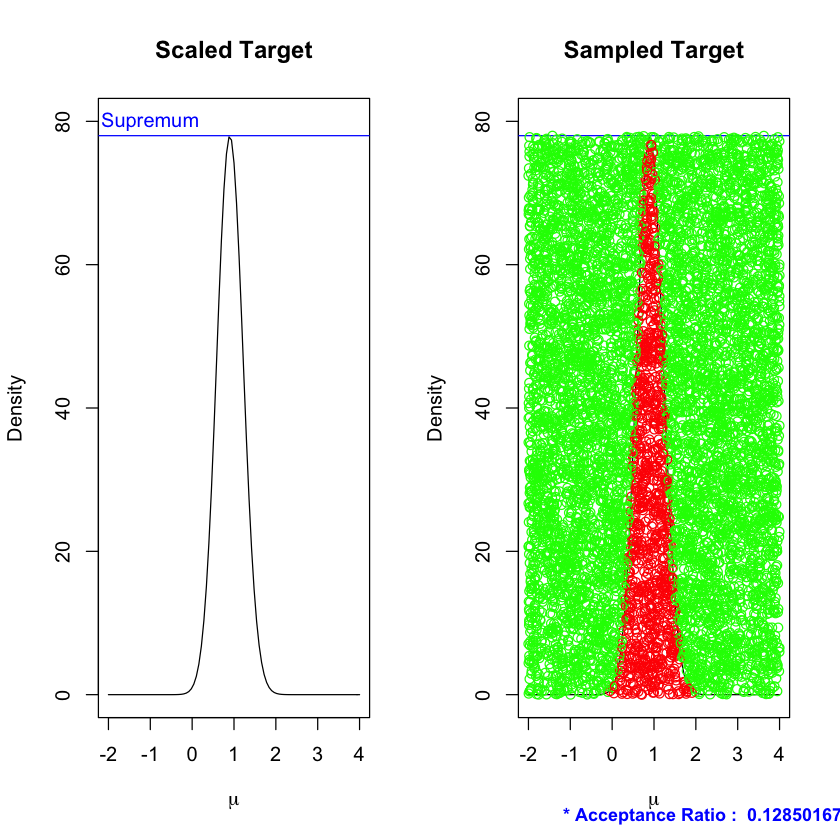

In [16]:
X_RS = rejection_sample_ploter(g, 1e3)

#### Comparison

|Method|MCMC|Rejection Sampling|
|------|------|---------------|
|**Validity**| Low | High|
|**Speed**| Fast | Slow|
|**Sample** | Inherently Dependent | Independent|
|**Meaning of Rejection** | No Move, but Keep | Discard|

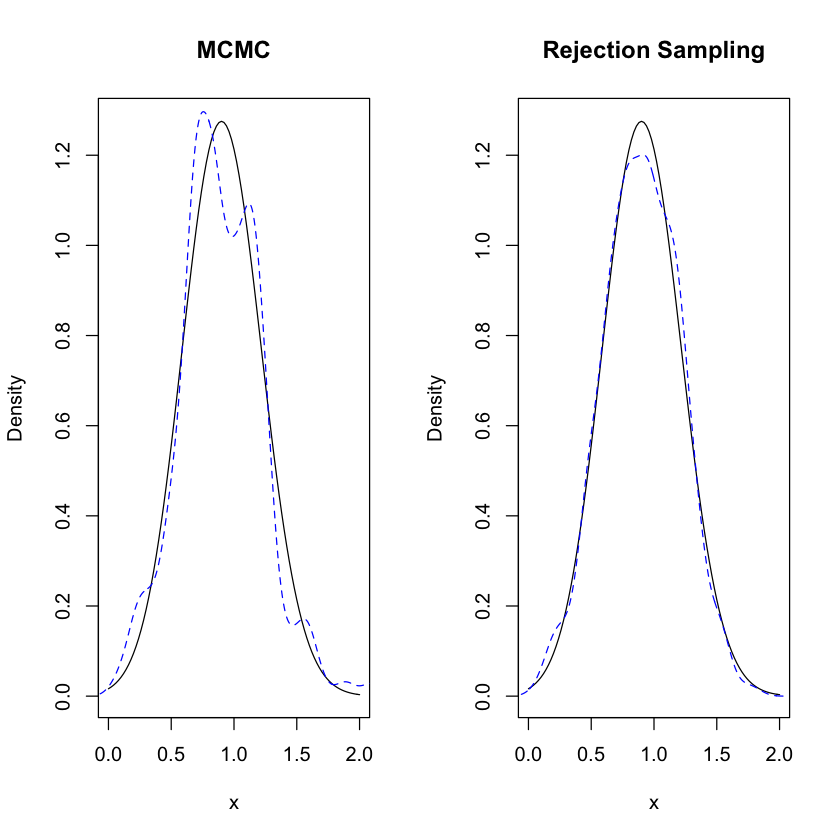

In [7]:
## validity

par(mfrow=c(1,2))
curve(g_scaled, xlim=c(0,2), main="MCMC", ylab="Density")
lines(density(X$theta), lty=2, col="blue")

curve(g_scaled, xlim=c(0,2), main="Rejection Sampling", ylab="Density")
lines(density(X_RS$sample), lty=2, col="blue")

In [8]:
## Speed

summary(microbenchmark(
    MCMC_method = MH(g, 1000, method = "dep.sym", theta_init=2, sd_proposal=1),
    Rejection_method = rejection_sampler(g, 1e3)
))

expr,min,lq,mean,median,uq,max,neval
MCMC_method,3.383304,3.789757,4.705096,4.433884,5.593597,10.60875,100
Rejection_method,27.717054,31.920457,34.982058,33.695984,35.300611,76.23929,100


### JAGS

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 10
   Unobserved stochastic nodes: 1
   Total graph size: 15

Initializing model




Iterations = 1501:2500
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
       0.90382        0.31716        0.01003        0.01382 

2. Quantiles for each variable:

  2.5%    25%    50%    75%  97.5% 
0.2926 0.6815 0.8870 1.1219 1.5372 


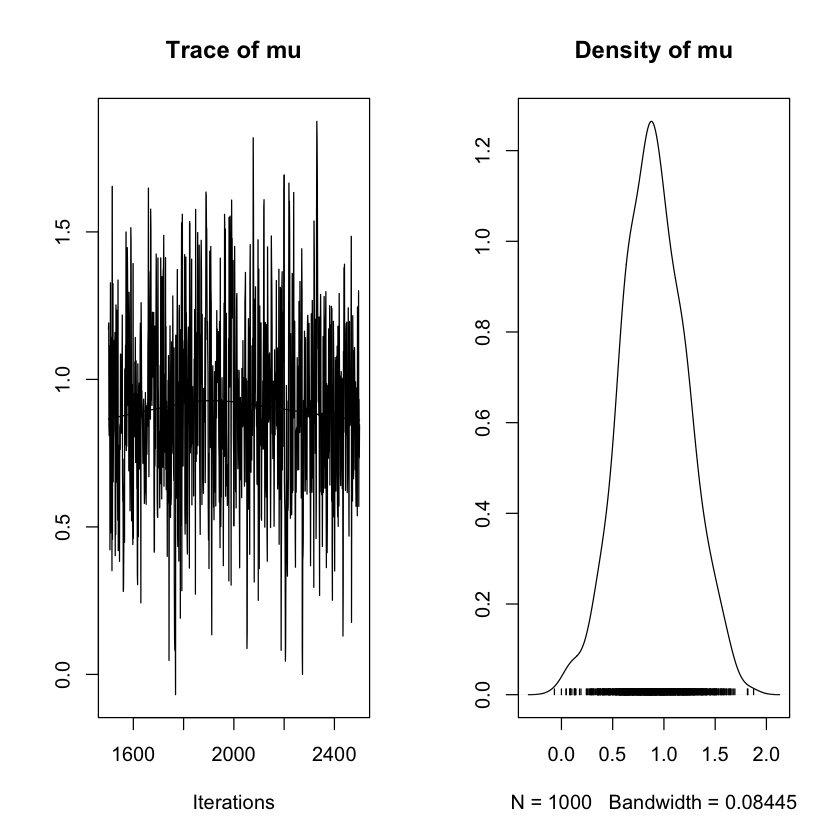

In [9]:
mod_jags_str ="  model 
{
  for(i in 1:n)
  {
    y[i] ~ dnorm(mu, 1.0/sig2)
  }
  
  mu   ~ dt(0.0, 1.0/1.0, 1)
  sig2 = 1.0
} "


data_jags   = list(y=y, n=n)
params_jags = c("mu")

inits = function()
{
  inits = list("mu"=0.0)
}

mod_jags = jags.model(textConnection(mod_jags_str), data=data_jags, inits=inits)
update(mod_jags, 500)
mod_jags_sim = coda.samples(model=mod_jags, variable.names = params_jags, n.iter = 1000)

summary(mod_jags_sim)

par(mfrow=c(1,2))
plot(mod_jags_sim)

### STAN

Inference for Stan model: STAN_model.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

      mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
mu    0.89    0.01 0.31  0.25  0.68  0.89  1.09  1.51   594    1
lp__ -4.31    0.02 0.72 -6.40 -4.47 -4.02 -3.85 -3.81  1020    1

Samples were drawn using NUTS(diag_e) at Tue Feb  6 09:27:05 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


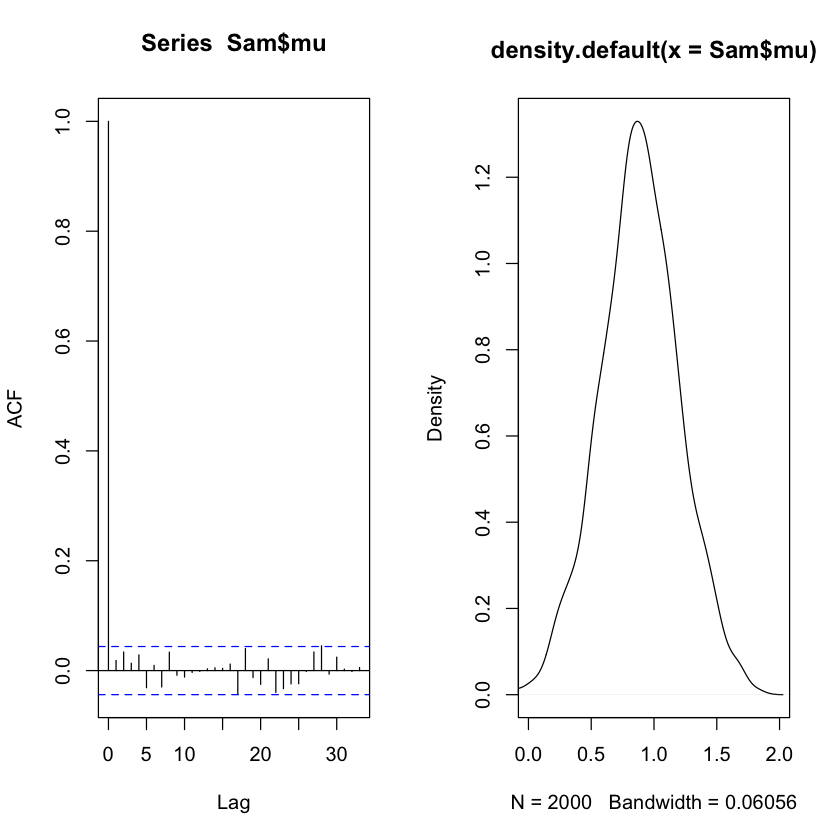

In [15]:
stan_model = "
data {
int n;
real y[n];
}

parameters {
real mu;
}

model { 
mu ~ student_t (1.0, 0.0, 1.0); 

for (i in 1:n) {
  y[i] ~ normal (mu, 1);
};

} "


data_stan = list(y=y, n=n)

# mod_stan = stan(model_code=stan_model, data=data_stan, iter = 1e3, model_name="STAN_model", verbose=F)
print(mod_stan)

Sam = extract(mod_stan)

par(mfrow=c(1,2))
acf(Sam$mu)
plot(density(Sam$mu), xlim = c(0,2))

## 5. Gibbs Sampling

### 5.1. Multiple Parameter Sampling and Full Conditional Distribution

**Idea** : update multiple parameters by **sampling just one parameter at a time** and **cycling through all parameters** and then repeating.

**Limitations** : requires full conditional distributions, and more iterations to fully explore the posterior.

Finding **full posterior distribution** is finding the **posterior distribution of each parameter**.

$$
\begin{aligned}
p(\theta, \phi \mid \mathbf{y}) &\propto g(\theta, \phi) \\[10pt]
p(\theta, \phi \mid \mathbf{y}) &= p(\phi \mid \mathbf{y}) p(\theta \mid \phi, \mathbf{y}) \\[15pt]
p(\theta \mid \phi, \mathbf{y}) &\propto p(\theta, \phi \mid \mathbf{y}) \propto g(\theta, \phi) \\[10pt]
p(\phi \mid \theta, \mathbf{y}) &\propto p(\theta, \phi \mid \mathbf{y})
\end{aligned}
$$

#### Algorithm

1. Initialize $\theta_0$, $\phi_0$.

2. for $i=1, \ldots, m$, repeat:

    a. Using $\phi_{i-1}$, draw $\theta_i \sim p(\theta \mid \phi_{i-1}, \mathbf{y})$
    
    b. Using $\theta_{i-1}$, draw $\phi_i \sim p(\phi \mid \theta_{i-1}, \mathbf{y})$

### 5.2. Conditionally Conjugate Prior Example with Normal Likelihood

Let us find **full conditional distribution** of $\mu$, $\sigma^2$, treating all the others as **constants**.

$$
\begin{aligned}
p(\mu, \sigma^2 \mid \mathbf{y}) &\propto (\sigma^2)^{(-\frac{n}{2})} 
    \ \ exp[-\frac{1}{2 \sigma^2}  \sum (y_i - \mu)^2] 
    \ \ exp[-\frac{1}{2 {\sigma_0}^2}  \sum (\mu - \mu_0)^2] 
    \ \ (\sigma^2)^{-(\nu_0+1)}
    \ \ exp[-\frac{\beta_0}{\sigma^2}] \\[15pt]
p(\mu \mid \sigma^2, \mathbf{y}) &\propto p(\mu, \sigma^2 \mid \mathbf{y}) \\[10pt]
&\propto  exp[-\frac{1}{2 \sigma^2}  \sum (y_i - \mu)^2] 
    \ \ exp[-\frac{1}{2 {\sigma_0}^2}  \sum (\mu - \mu_0)^2] \\[15pt]
p(\sigma^2 \mid \mu \mathbf{y}) &\propto p(\mu, \sigma^2 \mid \mathbf{y}) \\[10pt]
&\propto (\sigma^2)^{(-\frac{n}{2})} 
    \ \ exp[-\frac{1}{2 \sigma^2}  \sum (y_i - \mu)^2] 
    \ \ (\sigma^2)^{-(\nu_0+1)}
    \ \ exp[-\frac{\beta_0}{\sigma^2}] \\[15pt]
\end{aligned}
$$

$$
\begin{aligned}
\therefore \ \ \ \mu \mid \sigma^2, \mathbf{y} \sim
N(\mu \mid  \frac{n \bar{y}/ \sigma^2  +  μ_0 / \sigma_0^2 }
                {n \sigma^2 + 1/ \sigma_0^2},
          \frac{1}{n \sigma^2 + 1/ \sigma_0^2})\\[10pt]
\sigma^2 \mid \mu \sim
IG(\sigma^2 \mid \nu_0 + \frac{n}{2} , \beta_0 + \frac{\sum_i (y_i - \mu)^2} {2}) \\
\end{aligned}
$$

#### Example 

**Percent change in total personnel** of $n=10$ companies for 1 year.


+ **Prior** 

    $\mu \sim N(0, 1)$
    
    $\sigma^2 \sim IG(1, 1)$
    
+ **Likelihood** : $\mathbf{y} \mid \mu, \sigma \sim N(\mu, \sigma^2)$

+ **Goal** : $\mu, \sigma \mid \mathbf{y} \sim ?$

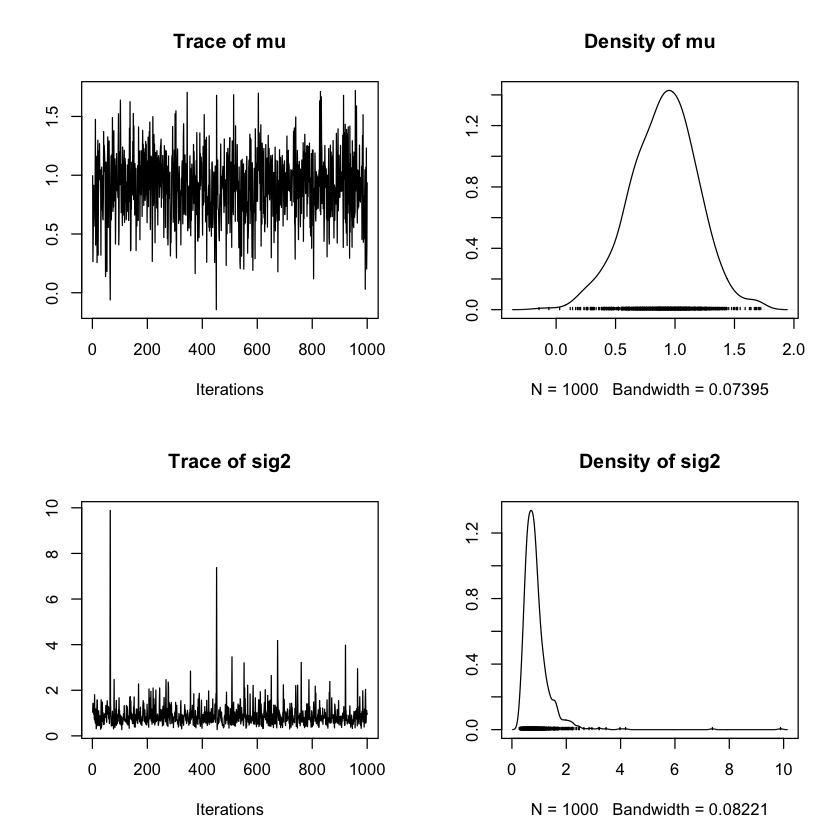

In [12]:
prior = list()
prior$mu_0 = 0.0
prior$sig2_0 = 1.0
prior$n_0 = 2.0
prior$s2_0 = 1.0 
prior$nu_0 = prior$n_0 / 2.0 
prior$beta_0 = prior$n_0 * prior$s2_0 / 2.0

init = list()
init$mu = 0.0

post = gibbs(y, n_iter=1e3, init=init, prior=prior)

par(mfrow=c(2,2))
plot(as.mcmc(post))

## 6. Assessing Convergence

### 6.1. Trace Plots, Autocorrelation

Why is it important to **check for convergence** before using the samples for inference?

If the chain has not reached its **stationary distribution**, the samples will not **reflect that distribution**.

It should not be showing any **long-term trends**. The average value for the chain should be roughly **flat**.

#### Autocorrelation

Measures how **linearly dependent** the current value of the chain is to past values called **lags**.

Tells **how much information** is available in our Markov chain.

#### Monte Carlo effective sample size

the number of independent samples from the stationary distribution that should be drawn to have **equivalent information** in the Markov chain.

### 6.2. Multiple Chains, Burn-in, Gelman-Rubin Diagnostic

Trace plots provide an **informal diagnostic** for the convergence of our chains. 

Can back up these visual results with the **Gelman and Rubin diagnostic**. 

Requires we fit **multiple chains**. 

Calculates the variability **within chains** and compares that to the variability **between the chains**. 

In [13]:
post1 = mh(n=n, ybar=ybar, n_iter=1e3, mu_init=15.0, cand_sd=0.4)
post2 = mh(n=n, ybar=ybar, n_iter=1e3, mu_init=-5.0, cand_sd=0.4)
post3 = mh(n=n, ybar=ybar, n_iter=1e3, mu_init=7.0, cand_sd=0.1)
post4 = mh(n=n, ybar=ybar, n_iter=1e3, mu_init=23.0, cand_sd=0.5)
post5 = mh(n=n, ybar=ybar, n_iter=1e3, mu_init=-17.0, cand_sd=0.4)

pmc = mcmc.list(as.mcmc(post1$mu), as.mcmc(post2$mu), 
                as.mcmc(post3$mu), as.mcmc(post4$mu), as.mcmc(post5$mu))

## More) 2D MCMC, 2D Rejection Sampling

Let us consider **the following** setting.

**Percent change in total personnel** of $n=10$ companies for 1 year.

+ **Prior** 

    $\mu \sim t(0, 1, 1)$
    
    $\sigma^2 \sim IG(1, 1)$
    
+ **Likelihood** : $\mathbf{y} \mid \mu, \sigma \sim N(\mu, \sigma^2)$

+ **Goal** : $\mu, \sigma \mid \mathbf{y} \sim ?$

Let us apply the concepts above to this **2-dimensional case**. We would be able to simply proceed to N-dimensional cases.

(For computational issues, I have added "1" to all the data. That is,

$$
\text{We have } \ \ \mathbf{y} = (2.2,2.4,0.5,1.3,1.9,3.3,2.0,1.1,2.3,2.9)
$$

### Example1 : 2D MCMC

**Proposal Distribution**

+ (red) $\ \ \ \mu^{*} \sim N(\mu_{i-1}, 0.4) \ \ $, ${\sigma^2}^{*} \sim IG({\sigma_{i-1}^2}^{*}, 1)$, $\mu_0 = 3, \ \  \sigma_0 =3 $

+ (green) $\mu^{*} \sim N(\mu_{i-1}, 0.4) \ \ $, ${\sigma^2}^{*} \sim IG({\sigma_{i-1}^2}^{*}, 1)$, $\mu_0 = 2, \ \  \sigma_0 =3 $

+ (blue) $\ \ \mu^{*} \sim N(\mu_{i-1}, 0.1) \ \ $, ${\sigma^2}^{*} \sim IG({\sigma_{i-1}^2}^{*}, 1)$, $\mu_0 = 1, \ \  \sigma_0 =3 $

1. Select an initial value $\theta_0 = [\mu_0, \sigma_0^2]$

2. For $(i = 1, \ldots, m)$, repeat the following steps:

    a. Draw a candidate sample $\theta^{*}= [\mu^{*}, {\sigma^2}^{*}]$ from each proposal distribution $N(\mu_{i-1}, \sigma^2_0)$, $IG(\sigma^2_{i-1}, 1)$.
    
    b. Compute the ratio (**defective** since the joint distribution of N & IG is **not symmetric** around center)
    
$$
\begin{aligned}
\alpha = \frac{g(\theta^*) }{g(\theta_{i-1})}
\end{aligned}
$$

   
   
$\ \ \ \ \ $ c. Proceed from $\theta_{i-1}$ to $\theta^{*}$ with the probability $A = min(1, \alpha)$.

### Example2 : 2D Rejection Sampling

+ **Prior** 

    $\mu \sim t(0, 1, 1)$
    
    $\sigma^2 \sim IG(1, 1)$
    
+ **Likelihood** : $\mathbf{y} \mid \mu, \sigma \sim N(\mu, \sigma^2)$

+ **Goal** : $\mu, \sigma \mid \mathbf{y} \sim ?$